In [ ]:
import numpy as np
import pandas as pd

import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import ValidationCurveDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

<h1><center>Validación de Modelos</center></h1>

<h2>Cross Validation (CV)</h2>

Uno de los problemas habituales que afrontamos cuando trabajamos con modelos de Machine Learning es el sesgo que se podría introducir en un modelo por la elección aleatoria de los conjuntos de testeo y entrenamiento. Podría suceder que se elija un conjunto de datos que produzca buenas métricas para el modelo pero que este sea solo un caso fortuito y que en realidad se tenga un modelo con bajo desempeño, esto se puede dar especialmente cuando los datos no están balanceados. Una de las principales estrategias para hacer frente a este problema es utilizar ***Cross Validation*** (CV). Existen múltiples técnicas de este tipo, la más común es conocida como *k-fold* CV y consiste en dividir el conjunto de entrenamiento (training set) en k partes, y luego utilizar cada una de estas  como conjunto de validación y el resto ($k-1$) como entrenamiento para el modelo, generandose así $k$ métricas (del mismo tipo), el promedio de estas será un mejor estimador del desempeño del modelo bajo prueba. 

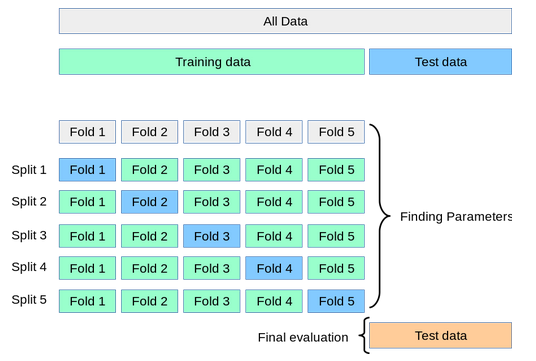

<br>
Imagen tomada de la <a src="https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation">documentación</a> de Sklearn.


En la imágen arriba el conjunto de entrenamiento fue dividido en $5$ subconjuntos y cada uno de ellos es utilizado en cada iteración como conjunto de validación.

Cuando un modelo es testeado con los mismos datos que fue entrenado se obtendrán excelentes métricas, pero estas no describen la realidad del modelo pues están prediciendo datos que ya han sido vistos por este, problema conocido como **overfiting**, un modelo que sólo puede entender los datos con los que fue entrenado. CV presenta una solución a este problema, pues siempre habrá un conjunto de datos que el modelo no está viendo y es este el que se utiliza como conjunto de validación. 

A continuación un ejemplo del uso de CV para el conjunto de datos que hemos venido trabajando.

In [ ]:
# Datos
path = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv"

df = pd.read_csv(path)
df.head()

In [ ]:
df.columns

In [ ]:
# Representacióon gráfica de la relación entre las features numéricas
hue="FUELTYPE"
sbn.pairplot(df, hue=hue)
plt.show()

In [ ]:
# Se propondrá un modelo polinómico para predecir la cantidad de emisiones de C02.
# 1. Escogemos nuestra variable predictora como FUELCONSUMPTION_COMB_MPG:
X = df[['FUELCONSUMPTION_COMB_MPG']]
y = df[['CO2EMISSIONS']]

fig = plt.figure(figsize=(6,6))
plt.scatter(x=X, y=y)
plt.xlabel("CO2EMISSIONS")
plt.ylabel("FUELCONSUMPTION_COMB_MPG")
plt.show()

Es siempre una buena práctica tener un conjunto de datos que se utilizarán para testeo al final del proceso de CV como se mostró en la anterior figura. 

In [ ]:
# 2. Datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2357)

<code>cross_val_score</code> permite realizar el proceso de CV con el fin de tener una mejor idea del desempeño del modelo. El modelo a utilizar es un ajuste polinómico de grado 2.

In [ ]:
# 3. modelo
degree = 2
model_p2 = make_pipeline(PolynomialFeatures(degree),  LinearRegression())

# 4. Cross validation
CV_p2 = cross_val_score(estimator=model_p2, X=X_train, y=y_train, cv=5, scoring="r2")

print(f"R² CV testing = {CV_p2}\nmean={CV_p2.mean():.4f} std = {CV_p2.std():.4f}")

El argumento *scoring* de <code>cross_val_score</code> también puede recibir una lista de las métricas con las cuales se quiere trabajar si es necesario. 

Ahora, una ves visto el desempeño del modelo con CV, procedemos a ver el verdadero desempeño del modelo realizando el entrenamiento con todos los datos y posteriormente calculando las metricas correspondientes.

In [ ]:
# 5. Entrenamiento utilizando todos los datos
model_p2 = make_pipeline(PolynomialFeatures(degree),  LinearRegression())
model_p2.fit(X=X_train, y=y_train)

In [ ]:
print(f"R2_training = {metrics.r2_score(y_pred=model_p2.predict(X_train),y_true=y_train)}")
print(f"R2_testing  = {metrics.r2_score(y_pred=model_p2.predict(X_test), y_true=y_test)}")

Estos resultados muestran poca discrepancia entre las métricas obtenidas con CV y los datos completos, lo cual es un resultado esperado. A continuación se presentará una de las principales utilidades del proceso de CV; la determinación de los *hiperparámetros* del modelo.

<h2>Sesgo vs Varianza</h2>

Antes de aplicar el método de CV es necesario dejar muy en claro cómo se determina que un modelo sea mejor que otro. La respuesta a esto viene de encontrar un punto óptimo entre sesgo y varianza. Un modelo que es incapaz de predecir incluso los datos con los que fue entrenado es un modelo sesgado (**underfiting**), sus métricas tanto de entrenamiento como de testeo son malas pues el modelo es incapaz de comprender el verdadero comportamiento de los datos. Por el otro lado, un modelo que tiene excelentes métricas de entrenamiento pero cuyas métricas de testeo son malas es un modelo con alta varianza (**overfiting**), es un modelo que se ha pegado tanto a sus datos de entrenamiento que no puede realizar ninguna predicción más allá de los datos que conoce. Claramente ninguno de los dos extremos es deseado, se busca entonces un punto donde tanto sesgo como varianza sean óptimos. 

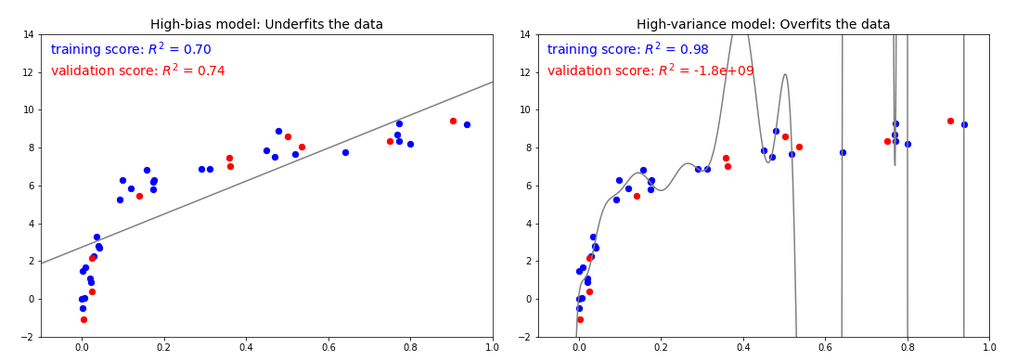

<a src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance-2.png?raw=true">Link imagen</a> 

Como se puede ver, el modelo con alto sesgo (bias) es intríncicamente incapaz de entender el comportamiento de los datos pues su naturaleza es de mayor complejidad que el modelo. Por otro lado, el modelo con alta varianza sólo puede entender los datos con los cuales fue entrenado (puntos en azul), no es capaz de realizar predicciones eficaces sobre el conjunto de testeo (puntos rojos). Se dice que el modelo tiene alta varianza pues al analizar las métricas del conjunto de testeo (por ejemplo un MSE) como los resultados obtenidos se alejan tanto de los esperados entonces la varianza del modelo explota (la suma cuadrática de los residuales del modelo crece muy rápidamente). 

Siendo así, el mejor modelo será aquel que presente un equilibrio entre sesgo y varianza. Si se grafica los valores obtenidos para las métricas de testeo y entrenamiento de un modelo, se esperaría que la curva de entrenamiento aumente de manera asintótica, indicando esto que el modelo, por más complejidad que tenga, no será capaz de aprender más de los datos, por otro lado, la curva de testeo deberá encontrar un valor máximo a partir del cual comenzará a descender. Este punto, donde comienza a disminuir el valor de la métrica de testeo, será el punto de equilibrio buscado y es este el que proporciona los mejores hiperparámetros para el modelo. 

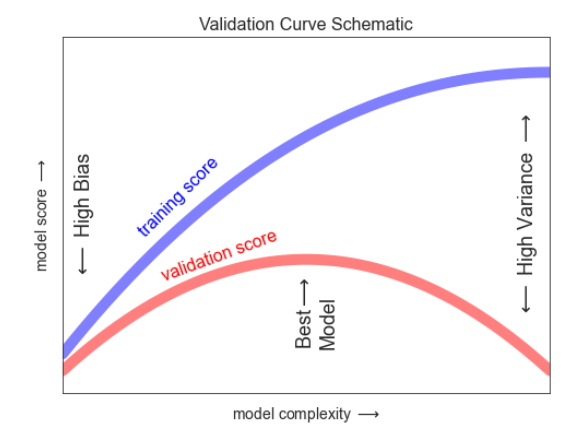

<a src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-validation-curve.png?raw=true">Link imagen</a>

<h3>Curvas de Validación</h3>

Una de las técnicas que se pueden utilizar para analizar el comportamiento del sesgo y la varianza del modelo es las *curvas de validación*. Con estas se muestra la influencia de un *único hiperparámetro* sobre el score. Es importante resaltar que este método sólo sería aplicable para analizar el comportamineto de un único hiperparámetro, en caso que se quiera analizar más de uno es recomendable utilizar GridSearch, además de que si son muchos los hiperparámetros a analizar la representación gráfica se vuelve mucho más compleja (con 2 hiperparámetros se necesitaría un gráfico 3D). 

La herramienta <code>validation_curve</code> de Sklearn realiza un proceso de CV para un conjunto de valores de un hiperparámetro y retorna las métricas de entrenamiento y testeo que son necesarias para costruir las curvas de validación que permitirán encontrar los mejores hiperparámetros. 

Continuando con el modelo polinómico anteriormente planteado, una duda tiene sentido ¿Cuál es el grado del polinomio que proporciona las mejores métricas? Utilicemos <code>validation_curve</code> para determinar esto. 

In [ ]:
# Modelo
def model_pn(degree=2):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Primero definimos el conjunto de grados del polinomio que se utilizarán.
degs = np.arange(1, 15, 1)

# Aplicamos validation_curve
training_score, validation_score = validation_curve(model_pn(), 
                                                    X=X_train, y=y_train,
                                                    cv=5, scoring="r2", 
                                                    param_name="polynomialfeatures__degree", param_range=degs)
training_score

In [ ]:
validation_score

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(degs, training_score.mean(axis=1),   label="training score",   c="k",   marker="o", alpha=0.7)
ax.plot(degs, validation_score.mean(axis=1), label="validation score", c="red", marker="o", alpha=0.7)

ax.set_xlim(min(degs), max(degs))
ax.set_xlabel("Polynomial degree (Complexity)")
ax.set_ylabel("Score $R^2$")
plt.xticks(ticks=degs, labels=degs)
ax.legend(frameon=False, loc="lower right")
ax.grid()
plt.show()

In [ ]:
degs[np.where(validation_score.mean(axis=1)==max(validation_score.mean(axis=1)))]

Según el resultado obtenido el polinomio de grado 7, es el que presenta el mejor valor del score de validación, pero esto no implica que sea este el que se deba elegir. Todos los polinomios de grados inferiores a 7 y mayores a 2 también presentan un buen score y no son computacionalmente tan complejos, por esto bastaría con un polinomio de grado 4 para obtener un buen modelo. Una discución sobre este último punto se presenta en el <a src="https://stats.stackexchange.com/questions/310953/doubt-about-k-fold-crossvalidation?noredirect=1&lq=1">enlace</a>. 

Otra alternativa para graficar la curva de validación es utilizar <code>ValidationCurveDisplay</code> de Sklearn. 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

ValidationCurveDisplay.from_estimator(estimator=model_pn(degree=2),
                                      X=X_train, y=y_train,
                                      param_name='polynomialfeatures__degree', param_range=degs, 
                                      ax=ax)

ax.set_xlim(min(degs), max(degs))
ax.set_xlabel("Polynomial degree (Complexity)")
ax.set_ylabel("Score $R^2$")
plt.xticks(ticks=degs, labels=degs)
ax.legend(frameon=False, loc="lower right")
ax.grid()
plt.show()

<h3>Curvas de aprendizaje</h3>

El desempeño del modelo no sólo dependerá de los valores de los hiperparámetros, otro aspecto que se debe tener muy presente es el tamaño del conjunto de entrenamiento. Adherir más datos de entrenamiento no necesariamente generará un mejor modelo. Una **curva de aprendizaje** muestra la variación en el score respecto al tamaño del conjunto de entrenamiento.

<code>learning_curve</code> nos ayuda a generar los datos necesarios para la contrucción de las curvas de aprendizaje retornando los tamaños de los subconjuntos de entrenamiento y los scores tanto de entrenamiento como de validación para el proceso de CV realizado para cada subconjunto de entrenamiento.

<code>learning_curve</code> empieza por dividir el conjunto de datos en $k=cv$ partes de aproximadamente igual tamaño para realizar el procedimiento de CV. Luego de esto crea cada uno de los subconjuntos de entrenamiento del tamaño indicado por los valores en el argumento *train_sizes* de <code>learning_curve</code> para entrenar el modelo (este subconjunto es tomado de las $k-1$ particiones restantes de los datos), se calcula la métrica deseada de entrenamiento y con la partición restante del proceso de CV se calculan las métricas de validación para ese subconjunto de entrenamiento. 

Con base a lo anterior existe un tamaño límite para los subconjuntos de entrenamiento que estaría dado por la cantidad de datos presentes en las $k-1$ particiones de los datos. Esto es:

\begin{equation}
    train\_sizes = \left(1, \ TOTAL\_DATOS\times\left(1-\frac{1}{k}\right) \right]
\end{equation}

In [ ]:
# Tamaño del conjunto de entrenamiento (porcentaje)
training_sizes = np.linspace(0.01, 1, 20)
cv = 5
#training_sizes = np.linspace(2, int(X.shape[0]*(1-1/cv)), 20, dtype=int)
print(f"Tamaños de entrenamiento: {training_sizes}")

N, training_score, val_score = learning_curve(
                                            estimator=model_pn(degree=4),
                                            X=X,
                                            y=y,
                                            train_sizes=training_sizes,
                                            cv=cv,
                                            scoring="r2",
                                            shuffle=True)

print(f"Tamaños de entrenamiento: {N}")

In [ ]:
#print(training_score, "\n\n", val_score)

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(N, training_score.mean(axis=1), label="Entrenamiento", color="red")
ax.plot(N, val_score.mean(axis=1),      label="Validación",    color="k")

ax.set_xticks(N)
ax.set_xticklabels([f"{i}\n{int(i/N[-1]*100)}%" for i in N], rotation=45)
ax.set_ylim(-1, 1.5)
ax.set_xlim(min(N), max(N))

ax.set_xlabel("Tamaño entrenamiento")
ax.set_ylabel("Score $R^2$")
ax.set_title(f"Curva de aprendizaje\nMáximo tamaño de entrenamiento = {N[-1]}")

ax.grid()
ax.legend(frameon=False, loc="lower center", ncol=2)
plt.show()